In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objective

While I guess I could use subsetted feats from prev LassoCV, I think the adj R2 of ~0.2 is low enough that I should be suspect of the features it had go to 0. I do want to avoid multicollinearity for the sake of interpreting the CI for ea feature, so I will remove some columns based on my EDA.

Let's see (1) how much I overfit, and (2) whether any features are statistically significant.

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

from transform_for_num_issues_pred import main as transform_dataset
from helper_functions import get_vifs

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import string
from StringIO import StringIO

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas, adjusted_r2, transform_school

In [4]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [5]:
df_orig = transform_school(df_orig)
df_orig.shape

../preprocessing/helper_functions.py:58: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df.school = df.school.str.extract(r'(\d\d?)').astype(int)


(516406, 40)

In [6]:
df_orig.head(1).T

,905425
CASE_ENQUIRY_ID,101001983786
OPEN_DT,2017-01-07 10:51:37
CLOSED_DT,2017-01-07 11:46:43
TYPE,Request for Snow Plowing
SubmittedPhoto,True
LOCATION_ZIPCODE,2124
Property_Type,Address
LATITUDE,42.2809
LONGITUDE,-71.068
Source,Citizens Connect App


In [7]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(534, 28)

## Dropping more outliers

To see if that improves the model. If so, the next question is, when do we stop removing outliers!?!

In [8]:
more_outliers = ['0107021', '0701011', '0806013'] # last one is Dudley

In [9]:
df_transformed = df_transformed[~df_transformed.tract_and_block_group.isin(more_outliers)]
df_transformed.shape

(531, 28)

In [10]:
df_transformed.head(1).T

,0
tract_and_block_group,1004002
race_white,0.242399
race_black,0.514358
race_asian,0.035473
race_hispanic,0.0675676
race_other,0.140203
poverty_pop_below_poverty_level,0
earned_income_per_capita,34340
poverty_pop_w_public_assistance,0.0597484
poverty_pop_w_food_stamps,0.138365


## Choosing columns

In [11]:
cols_orig_dataset = ['NUM_ISSUES_PER_1000_POP']
cols_census = [
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_census = [
     'race_black',
     'race_asian',
     'race_hispanic',
     'income',
     'earned_income_per_capita',
     ]

In [12]:
df_col_subset = df_transformed[cols_orig_dataset + cols_census]
df_col_subset.shape

(531, 6)

In [13]:
# this is a bad temporary band-aid
# df_col_subset = df_col_subset.dropna(subset=['income_std_dev', 'value_std_dev', 'rent_std_dev'])
df_col_subset = df_col_subset.dropna(subset=['income_std_dev'])

df_col_subset.shape

KeyError: ['income_std_dev']

## Dummify

In [15]:
cols_to_dummify = df_col_subset.dtypes[df_col_subset.dtypes == object].index
cols_to_dummify

Index([], dtype='object')

In [16]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df_col_subset, cols_to_dummify)

In [17]:
df_dummified.shape

(531, 6)

## Running model

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer


In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
df_dummified.columns = [col.translate(None, string.punctuation).replace(' ', '') if col != 'NUM_ISSUES_PER_1000_POP' else col for col in df_dummified.columns]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop(['NUM_ISSUES_PER_1000_POP'], axis=1), 
    df_dummified.NUM_ISSUES_PER_1000_POP, 
    test_size=0.2, 
    random_state=500
)

In [22]:
col_list = ' + '.join(df_dummified.drop('NUM_ISSUES_PER_1000_POP', axis=1))

est = smf.ols(
    'NUM_ISSUES_PER_1000_POP ~ {}'.format(col_list), 
    pd.concat([X_train, y_train], axis=1)).fit()

In [23]:
est.summary().tables[0]

Dep. Variable:,NUM_ISSUES_PER_1000_POP,R-squared:,0.219
Model:,OLS,Adj. R-squared:,0.210
Method:,Least Squares,F-statistic:,23.51
Date:,"Mon, 27 Feb 2017",Prob (F-statistic):,7.82e-21
Time:,14:25:51,Log-Likelihood:,-3072.7
No. Observations:,424,AIC:,6157.
Df Residuals:,418,BIC:,6182.
Df Model:,5,,
Covariance Type:,nonrobust,,


### Getting adjusted $R^2$ on test set

In [50]:
y_pred = est.predict(X_test)
y_train_pred = est.predict(X_train)

In [25]:
adjusted_r2(y_test, y_pred, num_features=X_test.shape[1])

0.14291061933335839

In [51]:
mean_squared_error(y_train, y_train_pred)**0.5

339.6961609993545

In [26]:
mean_squared_error(y_test, y_pred)**0.5

325.05133852975064

Darren said that having RMSE be similar for both my train and test sets, even if I'm overfitting, would help me make the claim that my model is "good".

In [27]:
df_results = pd.read_csv(StringIO(est.summary().tables[1].as_csv()), index_col=0).reset_index()
df_results.columns = ['coef_name'] + [i.rstrip().lstrip() for i in df_results.columns][1:]
df_results['coef_abs'] = pd.np.abs(df_results.coef)
df_results = df_results.sort_values('P>|t|')

In [28]:
df_results

,coef_name,coef,std err,t,P>|t|,[95.0% Conf. Int.],coef_abs
0,Intercept,834.4675,66.259,12.594,0.000,704.226 964.709,834.4675
3,racehispanic,-564.7507,113.450,-4.978,0.000,-787.755 -341.746,564.7507
2,raceasian,-463.3775,153.660,-3.016,0.003,-765.420 -161.335,463.3775
4,income,0.0006,0.000,2.046,0.041,2.43e-05 0.001,0.0006
5,earnedincomepercapita,0.0022,0.001,2.018,0.044,5.78e-05 0.004,0.0022
1,raceblack,-102.5882,77.659,-1.321,0.187,-255.238 50.062,102.5882


In [29]:
df_dummified.NUM_ISSUES_PER_1000_POP.describe()

count     531.000000
mean      808.103499
std       380.036978
min        36.706869
25%       568.811136
50%       764.800000
75%      1023.278856
max      2247.452693
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

In [30]:
y_test.describe()

count     107.000000
mean      820.152435
std       361.384984
min        36.706869
25%       565.499170
50%       817.136886
75%      1043.363556
max      1719.851577
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

## Compare to baseline model

which is just the mean

In [48]:
bb = y_train.mean() * pd.np.ones(y_test.shape)

In [49]:
adjusted_r2(y_test, bb, num_features=X_test.shape[1])

-0.051351993223162723

In [42]:
mean_squared_error(y_test, bb)**0.5

360.00868073413704

## Checking multicollinearity

which I could have done before I ran the model as well.

In [260]:
get_vifs(df_dummified, 'NUM_ISSUES_PER_1000_POP')

racewhite                42.030599
raceblack                31.152844
racehispanic             13.011776
raceasian                 6.675149
earnedincomepercapita     2.449680
income                    2.182038
school                    1.723420
dtype: float64

No VIFs around 5, so we're clear.

## Residuals plot

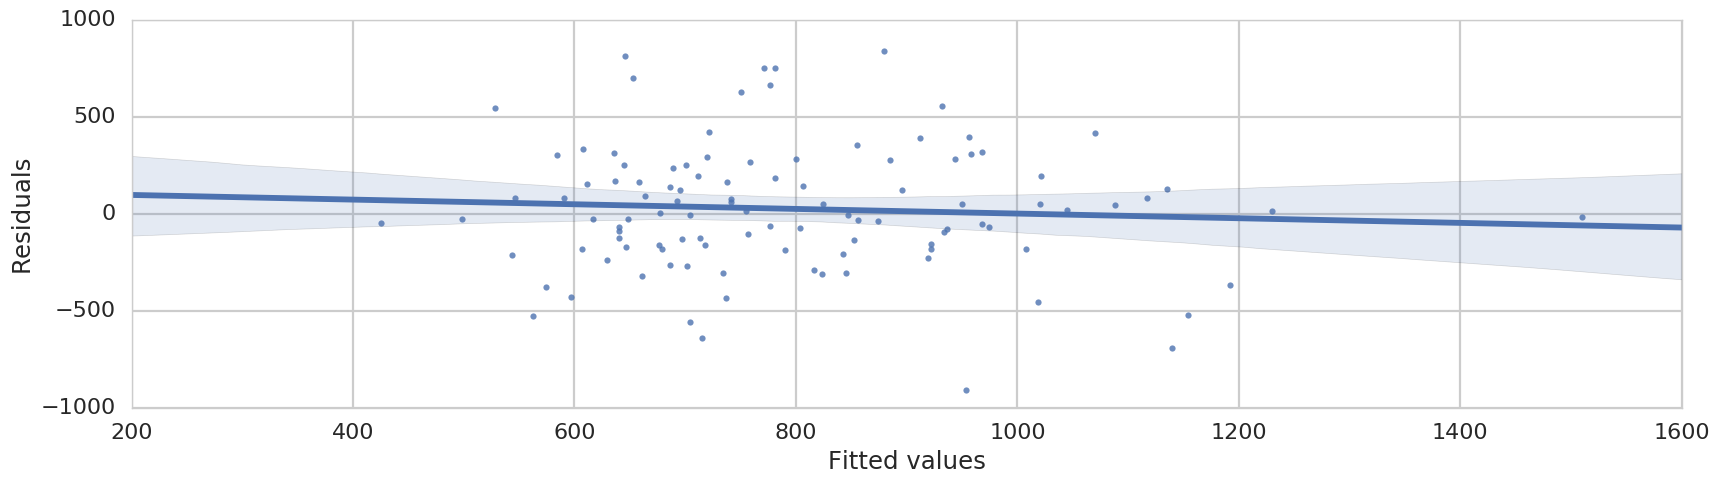

In [296]:
ax = sns.regplot(y_pred, y_test.as_matrix() - y_pred)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals');

- Data is visually linear, so that checks out
- Error terms are more or less equal distance from the line here, except for the one point around (600, 1450)

## Conclusion

- An area with more Hispanics or Asians is associated with fewer number of 311 issues, Hispanic moreso than Asian.
- A 10% increase in Hispanics is associated with 56 fewer issues, on average.
- A 10% increase in Asian is associated with 46 fewer issues, on average.
- For every \$10,000 increase in average income, that area is associated with 60 more 311 issues, on average.

### Commentary

Also, our metric `# of 311 issues` is an imperfect indicator for civic participation. `# of 311 issues` is not just a function of civic participation, but also for the volume of true issues in an area. For example, if there are more potholes in an area, it will have more pothole 311 issues, unless there are some that aren't reported.

Categories such as potholes are not so much a function of the socioeconomic makeup, per se. It's more correlated with how busy the road is.

I controlled for this by having my model pertain to residential areas, and removing commerical and industrial outliers. It is tricky, as there are some areas that are both havily commerical, and where people live.